# Full pipeline with EO-ML

Given: Embeddings from e.g. SSL4EO-L

Start out by just fitting a linear regressor and getting the same CDF width for all samples

In [1]:
import os
import pandas as pd
import configparser
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold, LeaveOneGroupOut, cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

RANDOM_STATE = 42

In [2]:
# Read config file
config = configparser.ConfigParser()
config.read('config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

embeddings = np.load(os.path.join(DATA_DIR, 'ssl4eo_resnet50.npy'))
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_img_data.csv'))

assert embeddings.shape[0] == df.shape[0], 'Mismatch between embeddings and metadata rows.'

df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944
...,...,...,...,...,...,...,...,...,...,...
68070,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567
68071,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878
68072,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326
68073,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344


In [3]:
class CDF_model:
    
    def __init__(self, model_class: str, **model_params):
        
        if model_class == 'Ridge':
            self.model = Ridge(**model_params)
        elif model_class == 'Lasso':
            self.model = Lasso(**model_params)
        elif model_class == 'ElasticNet':
            self.model = ElasticNet(**model_params)
        else:
            raise ValueError(f'Model class \"{model_class}\" is not supported')
        
    def fit(self, X, y):
        self.model.fit(X, y)
        
    def calibrate(self, X, y):
        y_pred = self.model.predict(X)
        self.residuals = np.sort(y - y_pred)
        
    def predict(self, X):
        y_pred = self.model.predict(X)
        y_pred = np.repeat(y_pred[:, np.newaxis], len(cdf_model.residuals), axis=1)
        y_pred += self.residuals
        return y_pred
    
cdf_model = CDF_model('Ridge')

## Test on one train-test split

In [4]:
X = embeddings
y = df['iwi'].values / 100.0 # Scale IWI to [0, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=.25, random_state=RANDOM_STATE)

print('y_train:', y_train.shape)
print('y_cal:', y_cal.shape)
print('y_test:', y_test.shape)

y_train: (40845,)
y_cal: (13615,)
y_test: (13615,)


In [5]:
cdf_model.fit(X_train, y_train)
cdf_model.calibrate(X_cal, y_cal)
y_pred = cdf_model.predict(X_test)

100%|██████████| 100/100 [00:00<00:00, 8338.25it/s]


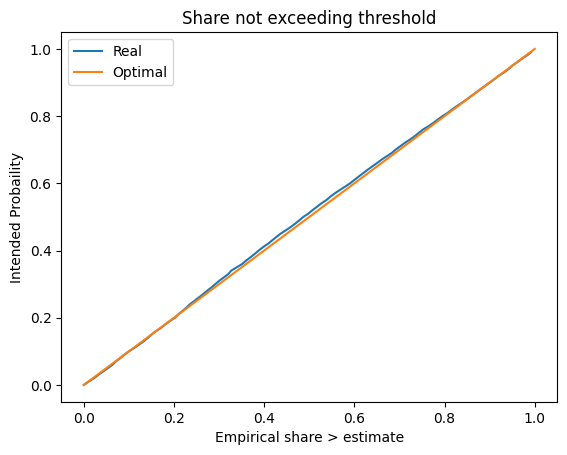

In [6]:
from tqdm import tqdm

emp_percs = []

percs = np.linspace(0, 0.99, 100)
for perc in tqdm(percs):
    index = int(perc * y_pred.shape[1])
    perc_pred = y_pred[:, index]
    emp_percs.append(np.mean(y_test < perc_pred))
    
plt.plot(emp_percs, percs, label='Real')
plt.plot([0, 1], [0, 1], label='Optimal')
plt.title('Share not exceeding threshold')
plt.xlabel('Empirical share > estimate')
plt.ylabel('Intended Probaility')
plt.legend()
plt.show()

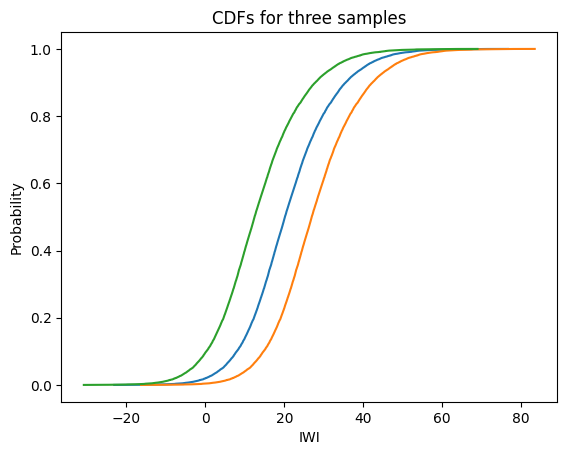

In [7]:
plt.plot(100*y_pred[0], np.linspace(0, 1, y_pred.shape[1]))
plt.plot(100*y_pred[1], np.linspace(0, 1, y_pred.shape[1]))
plt.plot(100*y_pred[2], np.linspace(0, 1, y_pred.shape[1]))
plt.title('CDFs for three samples')
plt.ylabel('Probability')
plt.xlabel('IWI')
plt.show()

## Plot hit distirbution

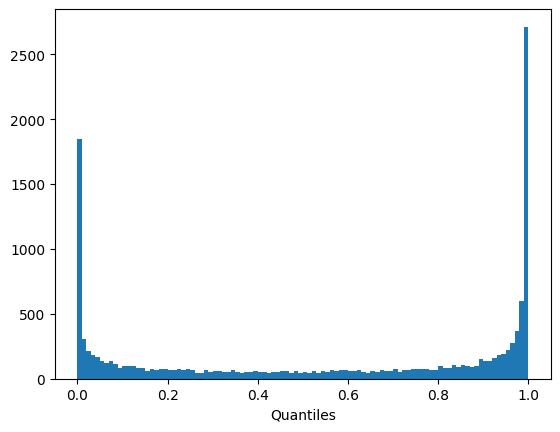

In [9]:
indices = np.array([np.searchsorted(row, y_i) for row, y_i in zip(y_pred, y)])
indices = indices / y_pred.shape[1]
plt.hist(indices, 100)
plt.xlabel('Quantiles')
plt.show()

# Experiment

Randomly assign treatment (i.e. ATE should be 0). Doesn't make much sense now that we don't have multiple samples

In [10]:
np.random.seed(RANDOM_STATE)
df['treated'] = np.random.binomial(1, 0.2, len(df)) == 1 # Get as boolean
df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi,treated
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459,False
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589,True
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211,False
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697,False
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944,False
...,...,...,...,...,...,...,...,...,...,...,...
68070,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567,False
68071,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878,True
68072,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326,False
68073,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344,False


In [11]:
X = embeddings
y = df['iwi'].values / 100.0 # Scale IWI to [0, 1]
t = df['treated'].values

In [12]:
from sklearn.utils import resample

n_boots = 100
n_cdf_rounds = 1000

ate_estimates = []

for i in tqdm(range(n_boots)):
    # Sample with replacement
    X_sample, y_sample, t_sample = resample(X, y, t, random_state=i)
    
    # Split into train, calibration and test sets
    X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X_sample, y_sample, t_sample, test_size=.2, random_state=RANDOM_STATE)
    X_train, X_cal, y_train, y_cal, t_train, t_cal = train_test_split(X_train, y_train, t_train, test_size=.25, random_state=RANDOM_STATE)
    
    # Fit model, calibrate and predict CDFs for test set
    sample_model = CDF_model('Ridge')
    sample_model.fit(X_train, y_train)
    sample_model.calibrate(X_cal, y_cal)
    y_pred = sample_model.predict(X_test)
    n_samples, n_quantiles = y_pred.shape
    
    sample_ate_estimates = []
    
    for j in range(n_cdf_rounds):
        
        indices = np.random.randint(0, n_quantiles, n_samples)
        draw_y_preds = y_pred[np.arange(n_samples), indices]
        
        # No confounders, so just diff
        ate_estimate = np.mean(draw_y_preds[t_test]) - np.mean(draw_y_preds[~t_test])
        sample_ate_estimates.append(ate_estimate)
        
    ate_estimates.append(sample_ate_estimates)

# Save as a dataframe for easier plotting
res_df = pd.DataFrame(ate_estimates).reset_index().melt(id_vars='index')
res_df.columns = ['Boot', 'CDF round', 'ATE estimate']

100%|██████████| 100/100 [03:19<00:00,  1.99s/it]


In [13]:
res_df

,Boot,CDF round,ATE estimate
0,0,0,0.008020
1,1,0,0.005503
2,2,0,-0.002486
3,3,0,-0.000959
4,4,0,0.011164
...,...,...,...
99995,95,999,0.003607
99996,96,999,-0.000863
99997,97,999,0.000833
99998,98,999,-0.004474


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


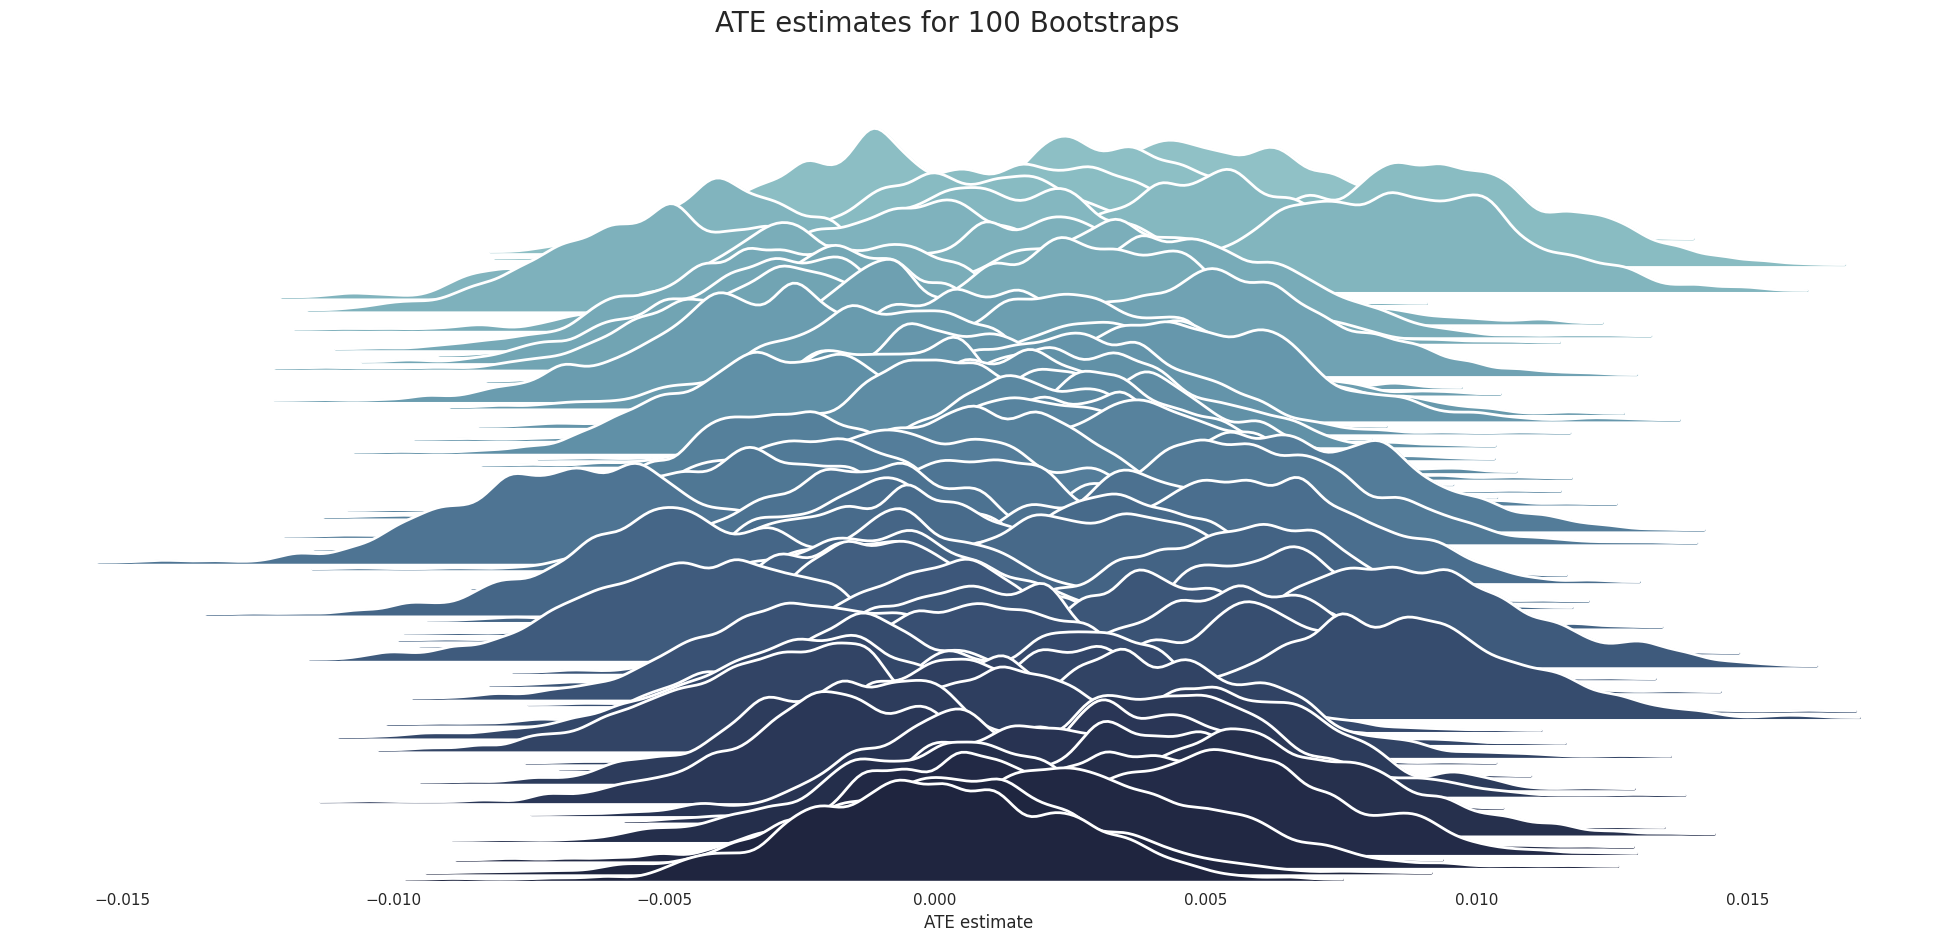

In [14]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(100, rot=-.25, light=.7)
g = sns.FacetGrid(
    res_df, row="Boot", hue="Boot", aspect=250, height=0.1, palette=pal
)

# Draw the densities in a few steps
g.map(sns.kdeplot, "ATE estimate",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "ATE estimate", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.95)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.suptitle("ATE estimates for 100 Bootstraps", fontsize=20)
plt.show()

In [21]:
def calculate_errors_from_df(df):
    
    # Calculate variance of ATE estimates within each bootstrap sample (for modeling error)
    grouped = df.groupby('Boot')['ATE estimate']
    row_variances = grouped.var()  # Variance within each bootstrap sample
    modeling_error = np.sqrt(row_variances.mean())  # Average variance and take sqrt
    
    # Calculate mean of ATE estimates for each bootstrap sample (for sampling error)
    row_means = grouped.mean()  # Mean for each bootstrap sample
    sampling_error = np.sqrt(row_means.var(ddof=1))  # Variance of the means and take sqrt
    
    return modeling_error, sampling_error

modeling_error, sampling_error = calculate_errors_from_df(res_df)

global_mean = res_df['ATE estimate'].mean()
z = norm.ppf(0.975)

# Confidence Interval using Sampling Error only
ci_sampling_only = (global_mean - z * sampling_error, global_mean + z * sampling_error)

# Total error combining modeling and sampling errors
total_error = np.sqrt(sampling_error**2 + modeling_error**2)

# Confidence Interval using both errors
ci_with_both_errors = (global_mean - z * total_error, global_mean + z * total_error)

print('Mean estimated ATE:', global_mean)
print('Sampling error:', sampling_error)
print('Modeling error:', modeling_error)
print('95% Confidence interval with just sampling error:', ci_sampling_only)
print('95% Confidence interval with both model and sampling error:', ci_with_both_errors)

Mean estimated ATE: 0.0014355672
Sampling error: 0.0032301338
Modeling error: 0.0023770689
95% Confidence interval with just sampling error: (-0.004895378739115604, 0.007766513057526955)
95% Confidence interval with both model and sampling error: (-0.006424895381430557, 0.009296029699841907)
